In [76]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [77]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [78]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

it means 1 color channel, height and width are 28

In [79]:
class_names = train_data.classes
print(len(train_data))
print(train_data.classes)

60000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Image shape: torch.Size([1, 28, 28])


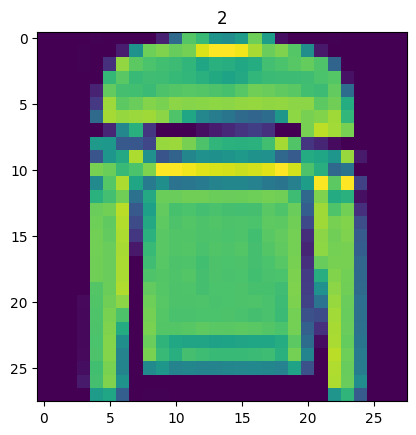

In [80]:
import matplotlib.pyplot as plt
image, label = train_data[5]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

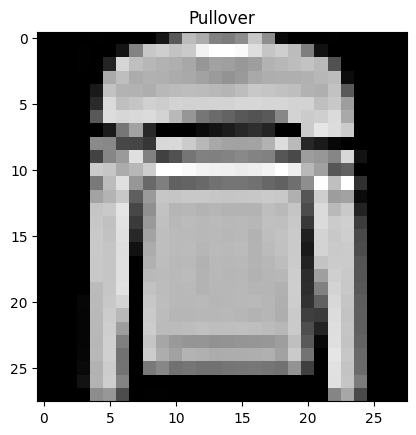

In [81]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

# Load Data

In [82]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [83]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Model

In [84]:
# Create a convolutional neural network
class Model(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_channels, hidden_units, kernel_size=3,
                      stride=1, padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print("shape after block1" + str(x.shape))
        x = self.block_2(x)
        # print("shape after block2" + str(x.shape))
        x = self.classifier(x)
        return x


In [85]:
model = Model(1, 8, len(class_names))
print(model)

Model(
  (block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=392, out_features=10, bias=True)
  )
)


In [86]:
# test_batch = torch.randn((32, 1, 28, 28))
# model.forward(test_batch)

### Here is the trick that we use to determine the number of input features. The error message says that 32x392 cannot be multiplied with 8x10, so we need to modify nn.Linear(in_features=hidden_units , out_features=output_shape) by changing into (in_features=hidden_units * 7 * 7 , out_features=output_shape)

# Training

In [87]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [88]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [89]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [90]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    # IMPORTANT!
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [92]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

Epoch: 0
---------
Train loss: 0.41955 | Train accuracy: 84.78%
Test loss: 0.41350 | Test accuracy: 84.93%

Epoch: 1
---------
Train loss: 0.40383 | Train accuracy: 85.43%
Test loss: 0.42766 | Test accuracy: 84.62%

Epoch: 2
---------
Train loss: 0.39415 | Train accuracy: 85.63%
Test loss: 0.42454 | Test accuracy: 84.84%

Epoch: 3
---------
Train loss: 0.38802 | Train accuracy: 85.87%
Test loss: 0.41805 | Test accuracy: 85.62%

Epoch: 4
---------
Train loss: 0.38470 | Train accuracy: 85.92%
Test loss: 0.42235 | Test accuracy: 84.93%

Epoch: 5
---------
Train loss: 0.38569 | Train accuracy: 85.77%
Test loss: 0.39229 | Test accuracy: 86.23%

Epoch: 6
---------
Train loss: 0.38476 | Train accuracy: 85.99%
Test loss: 0.41225 | Test accuracy: 85.13%

Epoch: 7
---------
Train loss: 0.38392 | Train accuracy: 86.03%
Test loss: 0.41283 | Test accuracy: 84.70%

Epoch: 8
---------
Train loss: 0.38299 | Train accuracy: 86.09%
Test loss: 0.40542 | Test accuracy: 85.61%

Epoch: 9
---------
Train los